## Start

In [1]:
!nvidia-smi

Fri Dec  4 18:18:32 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
import sys; sys.path.append('./stepik-dl-nlp')

In [3]:
!pip install pytorch-transformers

In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig
from pytorch_transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == 'cpu':
    print('cpu')
else:
    n_gpu = torch.cuda.device_count()
    print(torch.cuda.get_device_name(0))

Tesla T4


In [37]:
def convert_ids_to_string(tokenizer, ids):
    return tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(ids.tolist(), True))

def print_predict_result(labels, preds, tokenizer, data, labels_dict, samples_num=10):
    _labels = np.array(labels)
    _preds = np.array(preds)
    idx = np.arange(len(preds))
    pos_mask = _labels == _preds
    neg_mask = _labels != _preds
    pos_idx = idx[pos_mask]
    neg_idx = idx[neg_mask]
    pos_preds = _preds[pos_mask]
    neg_preds = _preds[neg_mask]
    neg_labels = _labels[neg_mask]
    pos_shuffle_idx = np.arange(len(pos_idx))
    neg_shuffle_idx = np.arange(len(neg_idx))
    np.random.shuffle(pos_shuffle_idx)
    np.random.shuffle(neg_shuffle_idx)
    
    for i in range(samples_num):
        print(f"[positive preds #{i}]")
        pred_idx = pos_preds[pos_shuffle_idx][i]
        print(f"  class: {labels_dict[pred_idx]}")
        text_idx = data[pos_idx[pos_shuffle_idx][i]][0]
        print(f"  text: {convert_ids_to_string(tokenizer, text_idx)}")
    
    print()

    for i in range(samples_num):
        print(f"[negative preds #{i}]")
        neg_pred_idx = neg_preds[neg_shuffle_idx][i]
        neg_label_idx = neg_labels[neg_shuffle_idx][i]
        print(f"  class pred:  {labels_dict[neg_pred_idx]}")
        print(f"  class label: {labels_dict[neg_label_idx]}")
        text_idx = data[neg_idx[neg_shuffle_idx][i]][0]
        print(f"  text: {convert_ids_to_string(tokenizer, text_idx)}")

## Download Lenta.ru dataset

In [ ]:
!wget -O lenta-ru-news.csv.bz2 https://github.com/yutkin/Lenta.Ru-News-Dataset/releases/download/v1.1/lenta-ru-news.csv.bz2
!bzip2 -d lenta-ru-news.csv.bz2

In [2]:
import pandas as pd

dataset = pd.read_csv('lenta-ru-news.csv', encoding='utf8')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
dataset.head()

,url,title,text,topic,tags,date
0,https://lenta.ru/news/1914/09/16/hungarnn/,1914. Русские войска вступили в пределы Венгрии,Бои у Сопоцкина и Друскеник закончились отступ...,Библиотека,Первая мировая,1914/09/16
1,https://lenta.ru/news/1914/09/16/lermontov/,1914. Празднование столетия М.Ю. Лермонтова от...,"Министерство народного просвещения, в виду про...",Библиотека,Первая мировая,1914/09/16
2,https://lenta.ru/news/1914/09/17/nesteroff/,1914. Das ist Nesteroff!,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",Библиотека,Первая мировая,1914/09/17
3,https://lenta.ru/news/1914/09/17/bulldogn/,1914. Бульдог-гонец под Льежем,Фотограф-корреспондент Daily Mirror рассказыва...,Библиотека,Первая мировая,1914/09/17
4,https://lenta.ru/news/1914/09/18/zver/,1914. Под Люблином пойман швабский зверь,"Лица, приехавшие в Варшаву из Люблина, передаю...",Библиотека,Первая мировая,1914/09/18


In [4]:
samples_per_topic = 10000
topic_labels = ['Экономика', 'Спорт', 'Культура', 'Наука и техника']

In [5]:
import unicodedata

titles = []
pre_sentences = []
labels = []
for i, topic_label in enumerate(topic_labels):
    buf = dataset.loc[dataset['topic'] == topic_label]
    titles += [unicodedata.normalize('NFKD', title) + '.' for title in buf['title'].head(samples_per_topic).tolist()]
    pre_sentences += buf['text'].head(samples_per_topic).tolist()
    # labels += [np.eye(len(topic_labels))[i].astype(int).tolist()] * samples_per_topic
    labels += [[i]] * samples_per_topic

## Full paper

In [6]:
sentences = [titles[i] + ' ' + pre_sentences[i] for i in range(len(labels))]

In [7]:
train_sentences, test_sentences, train_gt, test_gt = train_test_split(sentences, labels, test_size=0.3)

In [8]:
print(len(train_gt), len(test_gt))

28000 12000


In [9]:
from pytorch_transformers import BertTokenizer, BertConfig

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]

tokenized_texts = [['[CLS]'] + i[:510] + ['[SEP]'] if len(i) > 510 else ['[CLS]'] + i + ['[SEP]'] for i in tokenized_texts]

In [10]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(
    input_ids,
    maxlen=512,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

In [11]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, 
    train_gt, 
    random_state=42,
    test_size=0.1
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.1
)

train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=12
)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=12
)

In [12]:
from pytorch_transformers import AdamW, BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(topic_labels))
model.cuda()

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

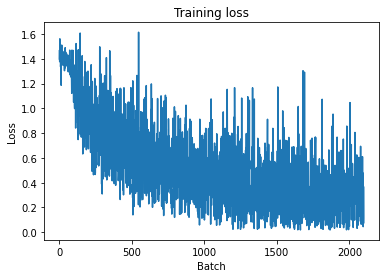

Loss на обучающей выборке: 0.53647


In [13]:
from IPython.display import clear_output

train_loss_set = []
train_loss = 0

model.train()
for step, batch in enumerate(train_dataloader):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    
    optimizer.zero_grad()
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss[0].item())  
    loss[0].backward()
    optimizer.step()

    train_loss += loss[0].item()
    
    clear_output(True)
    plt.plot(train_loss_set)
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.show()
print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))

In [14]:
model.eval()
valid_preds, valid_labels = [], []
for batch in validation_dataloader: 
    batch = tuple(t.to(device) for t in batch)
    
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)     
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

Процент правильных предсказаний на валидационной выборке: 90.96%


In [76]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in test_sentences]
tokenized_texts = [['[CLS]'] + i[:510] + ['[SEP]'] if len(i) > 510 else ['[CLS]'] + i + ['[SEP]'] for i in tokenized_texts]

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(
    input_ids,
    maxlen=512,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

In [77]:
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(test_gt)

prediction_data = TensorDataset(
    prediction_inputs,
    prediction_masks,
    prediction_labels
)

prediction_dataloader = DataLoader(
    prediction_data, 
    sampler=SequentialSampler(prediction_data),
    batch_size=10
)

In [78]:
model.eval()
test_preds, test_labels = [], []

for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)  
    test_preds.extend(batch_preds)
    test_labels.extend(batch_labels)

In [79]:
acc_score = accuracy_score(test_labels, test_preds)
print('Процент правильных предсказаний на отложенной выборке составил: {0:.2f}%'.format(
    acc_score*100
))

Процент правильных предсказаний на отложенной выборке составил: 90.48%


In [80]:
print('Неправильных предсказаний: {0}/{1}'.format(
    (np.array(test_labels) != np.array(test_preds)).sum(),
    len(test_labels)
))

Неправильных предсказаний: 1142/12000


In [81]:
print_predict_result(test_labels, test_preds, tokenizer, prediction_data, topic_labels)

[positive preds #0]
  class: Наука и техника
  text: израиль поставит колумбии модернизированные истребители . корпорация israeli aerospace industries ( iai ) в ближаишее время начнет модернизацию 24 истребителеи kfir для ввс колумбии , сообщает altair . договоренность о модернизации самолетов была достигнута во время визита министра обороны колумбии хуана мануэля сантоса в израиль . стоимость контракта составляет более 200 млн . долларов . модернизированные kfir должны заменить устаревшие истребители ввс колумбии , включая mirage 5 . ранее сообщалось , что для замены устаревших самолетов колумбия приобретет подержанные американские истребители f - 16a / b . предполагается , что истребители kfir будут модерн
[positive preds #1]
  class: Экономика
  text: россииские банкиры учредили фонд для лоббирования своих интересов в госдуме . ассоциация россииских банков ( арб ) учредила фонд для финансирования " законотворческих проектов " , сообщают " ведомости " . официальное название дочернеи 

## Title only

In [82]:
sentences = [titles[i] for i in range(len(labels))]

In [83]:
train_sentences, test_sentences, train_gt, test_gt = train_test_split(sentences, labels, test_size=0.3)

In [84]:
from pytorch_transformers import BertTokenizer, BertConfig

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]

tokenized_texts = [['[CLS]'] + i[:510] + ['[SEP]'] if len(i) > 510 else ['[CLS]'] + i + ['[SEP]'] for i in tokenized_texts]

In [85]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(
    input_ids,
    maxlen=512,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

In [87]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, 
    train_gt, 
    random_state=42,
    test_size=0.1
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.1
)

train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=12
)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=12
)

In [88]:
from pytorch_transformers import AdamW, BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(topic_labels))
model.cuda()

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

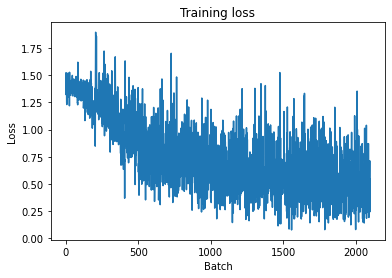

Loss на обучающей выборке: 0.76740
Процент правильных предсказаний на валидационной выборке: 83.57%


In [89]:
from IPython.display import clear_output

train_loss_set = []
train_loss = 0

model.train()
for step, batch in enumerate(train_dataloader):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    
    optimizer.zero_grad()
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss[0].item())  
    loss[0].backward()
    optimizer.step()

    train_loss += loss[0].item()
    
    clear_output(True)
    plt.plot(train_loss_set)
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.show()
print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))

model.eval()
valid_preds, valid_labels = [], []
for batch in validation_dataloader: 
    batch = tuple(t.to(device) for t in batch)
    
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)     
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

In [92]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in test_sentences]
tokenized_texts = [['[CLS]'] + i[:510] + ['[SEP]'] if len(i) > 510 else ['[CLS]'] + i + ['[SEP]'] for i in tokenized_texts]

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(
    input_ids,
    maxlen=512,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

In [93]:
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(test_gt)

prediction_data = TensorDataset(
    prediction_inputs,
    prediction_masks,
    prediction_labels
)

prediction_dataloader = DataLoader(
    prediction_data, 
    sampler=SequentialSampler(prediction_data),
    batch_size=10
)

In [94]:
model.eval()
test_preds, test_labels = [], []

for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)  
    test_preds.extend(batch_preds)
    test_labels.extend(batch_labels)

In [95]:
acc_score = accuracy_score(test_labels, test_preds)
print('Процент правильных предсказаний на отложенной выборке составил: {0:.2f}%'.format(
    acc_score*100
))

Процент правильных предсказаний на отложенной выборке составил: 82.94%


In [96]:
print('Неправильных предсказаний: {0}/{1}'.format(
    (np.array(test_labels) != np.array(test_preds)).sum(),
    len(test_labels)
))

Неправильных предсказаний: 2047/12000


In [97]:
print_predict_result(test_labels, test_preds, tokenizer, prediction_data, topic_labels)

[positive preds #0]
  class: Наука и техника
  text: на дальнем bостоке соревнуются ракетчики и артиллеристы .
[positive preds #1]
  class: Экономика
  text: квадратныи метр восстановленного жилья в якутии будет стоить 350 долларов .
[positive preds #2]
  class: Наука и техника
  text: nival online отправит россииских геимеров в страну пиратию .
[positive preds #3]
  class: Наука и техника
  text: в лас - вегасе показали usb 3 . 0 .
[positive preds #4]
  class: Наука и техника
  text: британские ученые разработали идеальныи сэндвич .
[positive preds #5]
  class: Наука и техника
  text: новые серверные станции от ibm оснастят процессорами amd .
[positive preds #6]
  class: Культура
  text: сотрудники " тис - кино " с милициеи захватили здание галереи " дом нащокина " .
[positive preds #7]
  class: Экономика
  text: на европеиских биржах продолжается падение курсов акции .
[positive preds #8]
  class: Наука и техника
  text: турция приобретет 100 истребителеи пятого поколения .
[positive

## First sentence

In [98]:
sentences = [pre_sentences[i].split('. ')[0] + '.' for i in range(len(labels))]

In [99]:
train_sentences, test_sentences, train_gt, test_gt = train_test_split(sentences, labels, test_size=0.3)

In [100]:
from pytorch_transformers import BertTokenizer, BertConfig

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]

tokenized_texts = [['[CLS]'] + i[:510] + ['[SEP]'] if len(i) > 510 else ['[CLS]'] + i + ['[SEP]'] for i in tokenized_texts]

In [101]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(
    input_ids,
    maxlen=512,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

In [102]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, 
    train_gt, 
    random_state=42,
    test_size=0.1
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.1
)

train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=12
)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=12
)

In [103]:
from pytorch_transformers import AdamW, BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(topic_labels))
model.cuda()

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

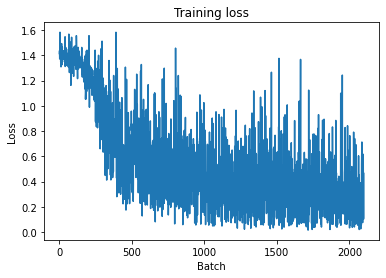

Loss на обучающей выборке: 0.56771
Процент правильных предсказаний на валидационной выборке: 89.46%


In [104]:
from IPython.display import clear_output

train_loss_set = []
train_loss = 0

model.train()
for step, batch in enumerate(train_dataloader):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    
    optimizer.zero_grad()
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss[0].item())  
    loss[0].backward()
    optimizer.step()

    train_loss += loss[0].item()
    
    clear_output(True)
    plt.plot(train_loss_set)
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.show()
print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))

model.eval()
valid_preds, valid_labels = [], []
for batch in validation_dataloader: 
    batch = tuple(t.to(device) for t in batch)
    
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)     
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

In [106]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in test_sentences]
tokenized_texts = [['[CLS]'] + i[:510] + ['[SEP]'] if len(i) > 510 else ['[CLS]'] + i + ['[SEP]'] for i in tokenized_texts]

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(
    input_ids,
    maxlen=512,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

In [107]:
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(test_gt)

prediction_data = TensorDataset(
    prediction_inputs,
    prediction_masks,
    prediction_labels
)

prediction_dataloader = DataLoader(
    prediction_data, 
    sampler=SequentialSampler(prediction_data),
    batch_size=10
)

In [108]:
model.eval()
test_preds, test_labels = [], []

for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)  
    test_preds.extend(batch_preds)
    test_labels.extend(batch_labels)

In [109]:
acc_score = accuracy_score(test_labels, test_preds)
print('Процент правильных предсказаний на отложенной выборке составил: {0:.2f}%'.format(
    acc_score*100
))

Процент правильных предсказаний на отложенной выборке составил: 89.60%


In [110]:
print('Неправильных предсказаний: {0}/{1}'.format(
    (np.array(test_labels) != np.array(test_preds)).sum(),
    len(test_labels)
))

Неправильных предсказаний: 1248/12000


In [111]:
print_predict_result(test_labels, test_preds, tokenizer, prediction_data, topic_labels)

[positive preds #0]
  class: Наука и техника
  text: две американских армеиских бригады закончили годовые испытания новых бронетранспортеров stryker в ираке , сообщает national defense magazine .
[positive preds #1]
  class: Наука и техника
  text: в результате столкновения американского боевого корабля и иностранного торгового судна в персидском заливе получили ранения четыре человека , сообщает afp .
[positive preds #2]
  class: Спорт
  text: на легкоатлетических соревнованиях в американском пеитон джордан один из сильнеиших спринтеров мира морис грин повторил мировои рекорд в беге на 100 метров , показав результат 9 , 78 секунды .
[positive preds #3]
  class: Экономика
  text: европеиская компания airbus и россииское верхнесалдинское металлургическое производственное объединение ( всмпо , в ртс : vsmo ) подписали дополнительныи долгосрочныи контракт , предусматривающии поставки титановых полуфабрикатов россииского производства для использования в производстве элементов конструкции с

## Random sentence

In [112]:
def rand_sentences(sent_list):
    import random
    random.shuffle(sent_list)
    result = sent_list[:random.randint(1,len(sent_list))]
    return '. '.join(result)
sentences = [rand_sentences(pre_sentences[i].split('. ')) for i in range(len(labels))]

In [113]:
train_sentences, test_sentences, train_gt, test_gt = train_test_split(sentences, labels, test_size=0.3)

In [114]:
from pytorch_transformers import BertTokenizer, BertConfig

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]

tokenized_texts = [['[CLS]'] + i[:510] + ['[SEP]'] if len(i) > 510 else ['[CLS]'] + i + ['[SEP]'] for i in tokenized_texts]

In [115]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(
    input_ids,
    maxlen=512,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

In [116]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, 
    train_gt, 
    random_state=42,
    test_size=0.1
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.1
)

train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=12
)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=12
)

In [117]:
from pytorch_transformers import AdamW, BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(topic_labels))
model.cuda()

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

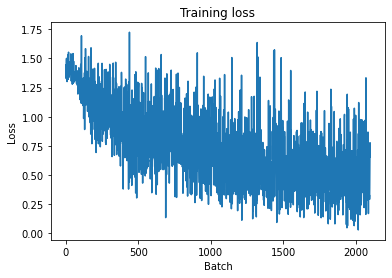

Loss на обучающей выборке: 0.74254
Процент правильных предсказаний на валидационной выборке: 82.57%


In [118]:
from IPython.display import clear_output

train_loss_set = []
train_loss = 0

model.train()
for step, batch in enumerate(train_dataloader):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    
    optimizer.zero_grad()
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss[0].item())  
    loss[0].backward()
    optimizer.step()

    train_loss += loss[0].item()
    
    clear_output(True)
    plt.plot(train_loss_set)
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.show()
print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))

model.eval()
valid_preds, valid_labels = [], []
for batch in validation_dataloader: 
    batch = tuple(t.to(device) for t in batch)
    
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)     
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

In [120]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in test_sentences]
tokenized_texts = [['[CLS]'] + i[:510] + ['[SEP]'] if len(i) > 510 else ['[CLS]'] + i + ['[SEP]'] for i in tokenized_texts]

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(
    input_ids,
    maxlen=512,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

In [121]:
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(test_gt)

prediction_data = TensorDataset(
    prediction_inputs,
    prediction_masks,
    prediction_labels
)

prediction_dataloader = DataLoader(
    prediction_data, 
    sampler=SequentialSampler(prediction_data),
    batch_size=10
)

In [122]:
model.eval()
test_preds, test_labels = [], []

for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)  
    test_preds.extend(batch_preds)
    test_labels.extend(batch_labels)

In [123]:
acc_score = accuracy_score(test_labels, test_preds)
print('Процент правильных предсказаний на отложенной выборке составил: {0:.2f}%'.format(
    acc_score*100
))

Процент правильных предсказаний на отложенной выборке составил: 81.94%


In [124]:
print('Неправильных предсказаний: {0}/{1}'.format(
    (np.array(test_labels) != np.array(test_preds)).sum(),
    len(test_labels)
))

Неправильных предсказаний: 2167/12000


In [125]:
print_predict_result(test_labels, test_preds, tokenizer, prediction_data, topic_labels)

[positive preds #0]
  class: Наука и техника
  text: в ходе модернизации штурмовик получил усовершенствованную электронику , аппаратуру постановки помех и новую кабину пилота , унифицированную с рабочим местом пилота на истребителях f - 16 последних серии . модернизация всего парка штурмовиков а - 10а в вариант а - 10с заимет два года . в течение 2007 года ввс сша должны получить 93 улучшенных самолета . . штурмовик а - 10c , в отличие от предыдущеи модификации а - 10а может выполнять боевые задачи независимо от погоды и времени суток и способен применять управляемые боеприпасы , например авиабомбы paveway ii , jdam и перспективные ракеты jcm ( joint common missiles )
[positive preds #1]
  class: Спорт
  text: ирландцы уже заявили , что их инвестиции в " мю " вызваны только финансовыми интересами , так как они чувствуют реальную отдачу от вложенных средств . в настоящее время цена всех акции клуба составляет примерно 622 миллиона фунтов стерлингов . . самыми крупными акционерами " мю "

## End